# Load dependencies and model

Load relevant libraries, the dataframe, and autoencoder model.

Dependencies: Keras, Python3, files for the dataframe and the training dataset.

In [1]:
import tensorflow as tf
import keras
import matplotlib
import pickle
import umap
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import pandas as pd

In [2]:
with open("./chair_ptclouds_ids.pkl", "rb") as f:
    chair_ptclouds_ids = pickle.load(f, encoding="latin1")

    
#plotting function author: @optas
def plot_3d_point_cloud(x, y, z, show=True, show_axis=True, in_u_sphere=False, marker='.', s=8, alpha=.8, figsize=(5, 5), elev=10, azim=240, axis=None, title=None, *args, **kwargs):

    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')        
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=elev, azim=azim)

    if in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        miv = 0.7 * np.min([np.min(x), np.min(y), np.min(z)])  # Multiply with 0.7 to squeeze free-space.
        mav = 0.7 * np.max([np.max(x), np.max(y), np.max(z)])
        ax.set_xlim(miv, mav)
        ax.set_ylim(miv, mav)
        ax.set_zlim(miv, mav)
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if 'c' in kwargs:
        plt.colorbar(sc)

    if show:
        plt.show()

    return fig


def plot_ptcloud(points):
    plot_3d_point_cloud(points[:,0], points[:,1], points[:,2])

In [3]:
ae = keras.models.load_model("../data/chair_ae_py3.h5")
encoder = ae.layers[1]
decoder = ae.layers[2]


In [4]:
semantic_df = pd.read_csv("../data/semantic-data.csv")

def find_match(dataset,dataframe, search_query, num_matches, dataframe_col="search_query"):
    if dataset=="all":
        return find_match_bag_of_words(dataframe, search_query, num_matches, dataframe_col="search_query" )
    else:
        return find_match_shapeglot(dataframe,search_query, num_matches, dataframe_col="search_query" )
    
def find_match_bag_of_words(dataframe, search_query, num_matches, dataframe_col="search_query"):
    hits =dataframe["bag_of_words"].str.find(search_query)
    
    hits = dataframe["name"].where(hits > -1).dropna().index
    
    
    set_of_hits = [int(hits.values[i]) for i in range(min(len(hits), num_matches)) ] 
    
    print(dataframe.iloc[set_of_hits]["bag_of_words"])
    result_pointclouds = [chair_dict[i] for i in dataframe.iloc[set_of_hits]["name"]] 
    related_words = dataframe.iloc[dataframe.iloc[set_of_hits]["name"].index]["bag_of_words"].str.cat(sep =",")
#     related_words = ",".join(related_words.split(" ")[:4])
    
    return result_pointclouds, related_words

def find_match_shapeglot(dataframe, search_query, num_matches, dataframe_col="search_query"):
    hits =dataframe["shapeglot"].str.find(search_query)
    
    hits = dataframe["name"].where(hits > -1).dropna().index
    
    
    set_of_hits = [int(hits.values[i]) for i in range(min(len(hits), num_matches)) ] 
    
    print(dataframe.iloc[set_of_hits]["shapeglot"])
    result_pointclouds = [chair_dict[i] for i in dataframe.iloc[set_of_hits]["name"]] 
    related_words = dataframe.iloc[dataframe.iloc[set_of_hits]["name"].index]["shapeglot"].str.cat(sep =",")
#     related_words = ",".join(related_words.split(" ")[:4])
    
    return result_pointclouds, related_words

# Dimensionality Reduction

Apply dimensionality reduction through UMAP. We apply the dimensionality reduction on the encoded data.

In [5]:
sns.set(context="paper", style="white")
reducer = umap.UMAP(n_components=2,random_state=42)



In [6]:
color_palette = sns.color_palette("husl", 12)


In [7]:
encoded_training_data = ae.layers[1].predict(chair_ptclouds_ids[0].reshape(6778,2048,1,3))

In [8]:
def normalize_embedding(embedding):
    
    norm_embedding = embedding.copy()
    original_translation_ax0 = -1* norm_embedding[:,0].min()
    original_translation_ax1 = -1 * norm_embedding[:,1].min()

    norm_embedding[:,0] += original_translation_ax0
    norm_embedding[:,1] += original_translation_ax1

    original_scale_ax0  = norm_embedding[:,0].max()
    original_scale_ax1 = norm_embedding[:,1].max()

    norm_embedding[:,0]  /= original_scale_ax0
    norm_embedding[:,1] /=  original_scale_ax1
    
    return {'embedding': norm_embedding, 'translation':(original_translation_ax0, original_translation_ax1), 'scale':(original_scale_ax0, original_scale_ax1)}


In [9]:
embedding = reducer.fit_transform(encoded_training_data.reshape(6778,128))


In [10]:
normalize_embedding_dict = normalize_embedding(embedding)
norm_embedding = normalize_embedding_dict['embedding']
translation_axis0 = normalize_embedding_dict['translation'][0]
translation_axis1 = normalize_embedding_dict['translation'][1]
scale_axis0 = normalize_embedding_dict['scale'][0]
scale_axis1 = normalize_embedding_dict['scale'][1]

In [11]:

kmeans = KMeans(n_clusters=12, random_state=0).fit(embedding)

umap_colors = kmeans.predict(embedding)
umap_colors.flatten()

cluster_colors = np.array([color_palette[cluster_index] for cluster_index in umap_colors]).flatten()
norm_embedding = np.array([[x,y,0] for x,y in norm_embedding])

In [12]:
clusters_denormed = [[(cluster_center[0] + translation_axis0) / scale_axis0, (cluster_center[1] + translation_axis1) / scale_axis1] for cluster_center in kmeans.cluster_centers_]
clusters_denormed = np.array(clusters_denormed)

After clustering and creating an embedding, we scale and translate it such that it fits within a unit square.

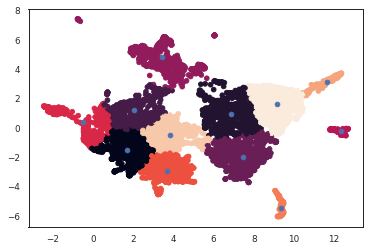

In [13]:
plt.scatter(embedding[:,0], embedding[:,1], c = umap_colors)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])

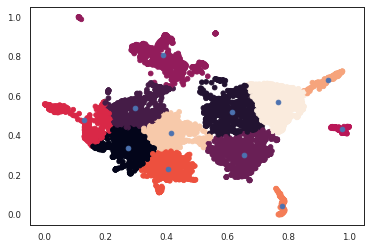

In [14]:
plt.scatter(norm_embedding[:,0],norm_embedding[:,1], c = umap_colors)
plt.scatter(clusters_denormed[:,0], clusters_denormed[:,1])

In [15]:
def get_centroid_ptclouds(centers):
    
    inverted_centers = [reducer.inverse_transform(np.array(center).reshape((1,2))) for center in centers]
    
    ptclouds_from_centers = [decoder.predict(latent_center.reshape(1,1,1,128)) for latent_center in inverted_centers]
    return ptclouds_from_centers

In [16]:
centers = kmeans.cluster_centers_
ptclouds_from_centers = get_centroid_ptclouds(centers)
centroid_ptclouds = np.array(ptclouds_from_centers).flatten()

In [17]:
colors = np.array([color_palette[i] for i in range(len(color_palette))]).flatten()

# Flask Application

In [18]:
import flask
from flask import Flask, send_file, request, jsonify, g
from werkzeug.exceptions import BadRequest
from werkzeug.utils import secure_filename


In [19]:
with open("dim_expansion_10000.pkl", "rb") as f:
    dim_expansion_test = pickle.load(f)

In [20]:
app = Flask(__name__)

#handles web requests from unity
@app.route('/', methods=["POST"])
def evaluate():
#     search_hits, related_words = find_match("shapeglot", semantic_df, search_query, 4)
    num_results = 0
    related_words = ""
    dim_reduction_map = norm_embedding.flatten()
    
    
    xyz_string = ",".join([str(pt) for pt in dim_reduction_map])
    color_string = ",".join([str(pt) for pt in  cluster_colors])
    
    centroids_string = ",".join([str(pt) for pt in centroid_ptclouds])
    centroids_xy = ",".join([str(pt) for pt in centers])
    
    colors_str= ",".join([str(pt) for pt in colors])
    return jsonify({'num_results':num_results, 'colors':colors_str, 'centroids_xy': centroids_xy, 'centroids_ptclouds':centroids_string, 'points_positions': xyz_string, "related_words" :related_words, "cluster_colors" : color_string})
    
@app.route('/hover', methods=["POST"])
def hover():
    point_index = int(request.form["point_index"].encode('utf8'))
    
    pointcloud = decoder.predict(np.expand_dims(encoded_shapeglot[point_index],0)).flatten()
    
    xyz_string = ",".join([str(pt) for pt in pointcloud])

    related_words=""
    
#     print(point_index)
#     print(labeled_ids[point_index])
#     
    database_row = point_index
#     print(database_row)
#     print("next")
#     descriptors = list(semantic_df["shapeglot"]
    descriptors = list(semantic_df.iloc[database_row]["shapeglot"])
    
    swow_words = list(semantic_df.iloc[database_row]["swow"])
    wordnet_words = list(semantic_df.iloc[database_row]["wordnet"])
    cluster_description = word_clusters[semantic_df.iloc[database_row]["colors"]]
    
    
    if len(swow_words):
        swow_words = "".join(swow_words)

        
    if len(wordnet_words):
        wordnet_words = "".join(wordnet_words)
 
    if len(descriptors):

        related_words ="".join(descriptors)
      
        
    num_results = 0
    
    return jsonify({'points_positions': xyz_string, "related_words": related_words, 'num_results':num_results, "swow_words": swow_words, "search_reasons":"", "wordnet_words": wordnet_words, "cluster_description":cluster_description})


@app.route('/generate', methods=["POST"])
def generate():
    
    point_x = float(request.form["pos_x"].encode('utf8'))
    point_y = float(request.form["pos_y"].encode('utf8'))
    
    point = np.array([point_x * scale_axis0 - translation_axis0, point_y * scale_axis1 - translation_axis1]).reshape(1,2)
    
    point_x = round(point_x,2)
    point_y = round(point_y,1)
    
#     inverse_umap = reducer.inverse_transform(point)

#     print(point)
    point_as_key = (point_x, point_y)

    if point_as_key in dim_expansion.keys():
        inverse_umap = dim_expansion[point_as_key]
    else:
        inverse_umap = dim_expansion[(point_as_key[0], point_as_key[1] + 0.01)]
    
    inverse_latent_dim = inverse_umap.reshape((1,1,1,128))

    inverse_decoded = decoder.predict(inverse_latent_dim).reshape(1,2048,1,3).flatten()

    cluster_strings = cluster_descriptors
    xyz_string = ",".join([str(pt) for pt in inverse_decoded])
    return jsonify({'num_results':"", 'points_positions': xyz_string, 'search_reasons': "", 'cluster_descriptors':cluster_strings})
    

@app.route('/search', methods=["POST"])
def search():
    search_query = request.form["search_query"].encode('utf8')
    search_hits, related_words = find_match("shapeglot", semantic_df, search_query, 4)
    
    encoder = semantic_net.layers[-1].layers[-2]
    decoder = semantic_net.layers[-1].layers[-1]
    
    pointcloud_hits = [encoder.predict(result_pointcloud.reshape(1,2048,1,3)) for result_pointcloud in search_hits]
    num_results = len(pointcloud_hits)
    encoded_base = pointcloud_hits[0]
    pointcloud_hits = np.array([decoder.predict(pointcloud) for pointcloud in pointcloud_hits]).flatten()
    
    xyz_string = ",".join([str(pt) for pt in pointcloud_hits])

    return jsonify({'num_results':num_results, 'points_positions': xyz_string, 'search_reasons': related_words})
    

@app.route('/subcluster', methods=["POST"])    
def subclusters():
    cluster_number = int(request.form["cluster_number"].encode('utf8'))
  
    return jsonify(subcluster_dict[cluster_number])
    

# Representative Words / Creating Word Clusters

Find the labeled pointclouds from the training data first.

In [21]:
cluster_descriptors = ['long legs back ridges taller seat square seat thickest seat rounded seat thin seat curved seat middle seat straight legs',
 'back cushion circular seat solid arm big seat skinny legs back spaces back head top legs small legs back padding',
 'thicker seat rounded seat straight legs high back thick legs taller legs fatest legs back legs slatted wood individual legs',
 'long legs solid seat rectangular seat square seat rounded seat single seat wide seat short seat straight legs solid legs',
 'back seat round seat rounded seat bottom seat joined seat wide seat solid legs square stool single leg wooden slats',
 'curved seat foor stool bottom fan lean long lunge separate foot farthest slatted patio multi segmented longest',
 'slatted seat back poles high seat square seat tiny seat back seat smallest seat long legs back piece tall arm',
 'double seat long legs whole seat square seat tall arm rounded seat flat seat wide seat top seat high seat',
 'bottom seat straight back single leg solid legs seprate legs thin legs square curved bar slim solid curve',
 'separate couch long couch back seats wavy legs top legs curved arms straight similar slats curved wider arms',
 'thicker seat regular leg back seat back slots square seat padded seat flat seat straight legs thick legs ish back',
 'round seat detailed arm whole seat square seat comfy arm wide seat solid arm shaped seat straight legs higher seat']

In [22]:
cluster_descriptors = "|".join(cluster_descriptors)

In [23]:
import pickle
with open("dim_expansion_10000.pkl", "rb") as f:
    dim_expansion = pickle.load(f)

# Creating subclusters

In [24]:

# kmeans_cluster = KMeans(n_clusters=12, random_state=0).fit(embedding)
# kmeans.labels_

# umap_colors = kmeans.predict(embedding)
# umap_colors.flatten()

# cluster_colors = np.array([color_palette[cluster_index] for cluster_index in umap_colors]).flatten()
# norm_embedding = np.array([[x,y,0] for x,y in norm_embedding])

In [25]:
ptcloud_ids = [name.split("_")[1] for name in chair_ptclouds_ids[1]]

In [26]:
zip(ptcloud_ids, umap_colors)

In [27]:
ptcloud_clusters_df=pd.DataFrame(data={"ids":ptcloud_ids, "colors":umap_colors, "index":list(range(len(ptcloud_ids)))})

In [28]:
ptcloud_clusters = dict(ptcloud_clusters_df.groupby("colors").groups)

In [29]:
encoded_clusters = [encoded_training_data[ptcloud_clusters[i]] for i in ptcloud_clusters.keys()]

In [30]:
encoded_clusters = [cluster.reshape(cluster.shape[0], 128) for cluster in encoded_clusters]

In [31]:
cluster_embeddings = [reducer.transform(cluster) for cluster in encoded_clusters]


In [32]:
# normalized_embedding_dicts = [normalize_embedding(cluster_embeddings[i]) for i in range(12)]


def normalize_subcluster(subcluster, translate_ax0, translate_ax1, scale_ax0, scale_ax1):
    subcluster[:,0] += translate_ax0 
    subcluster[:,1] += translate_ax1
    subcluster[:,0] /= scale_ax0
    subcluster[:,1] /= scale_ax1
    return subcluster
    
    
normalized_embeddings = [normalize_subcluster(subcluster,translation_axis0, translation_axis1, scale_axis0, scale_axis1 ) for subcluster in cluster_embeddings]

In [33]:
kmeans_per_cluster = [KMeans(n_clusters=4, random_state=0).fit(cluster) for cluster in normalized_embeddings]

In [34]:
num_clusters = 12

In [35]:
per_cluster_colors = [kmeans_per_cluster[cluster_index].predict(normalized_embeddings[cluster_index]) for cluster_index in range(num_clusters)]

In [36]:
def desaturate(cluster_index, subcluster_index):
    r = (float(color_palette[cluster_index][0])  * (subcluster_index + 1 )/ 5)
    g = (float(color_palette[cluster_index][1])  * (subcluster_index + 1 )/ 5)
    b = (float(color_palette[cluster_index][2])  * (subcluster_index + 1 )/ 5)
    return [r,g,b]

In [37]:
actual_cluster_colors = {}
for cluster_idx in range(num_clusters):
    cluster = per_cluster_colors[cluster_idx]
    subcluster_colorvals=[desaturate(cluster_idx, subcluster_idx ) for subcluster_idx in cluster]
    actual_cluster_colors[cluster_idx] = np.array(subcluster_colorvals)

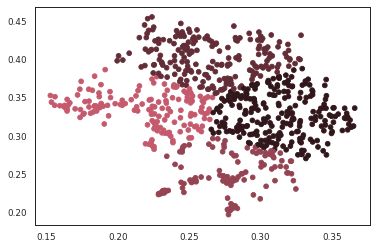

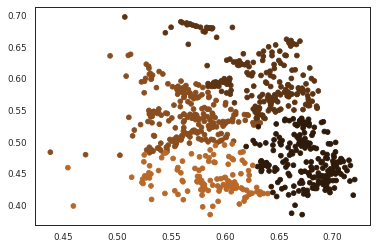

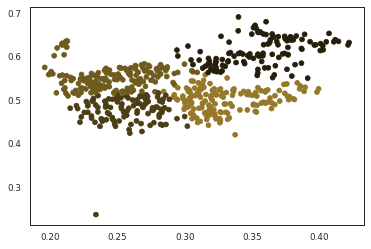

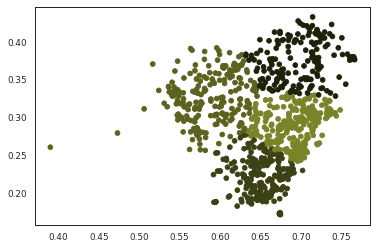

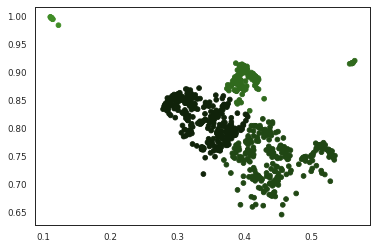

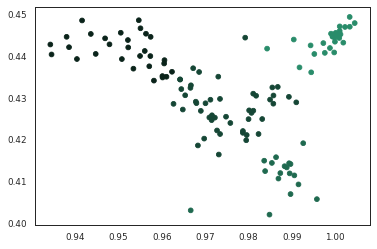

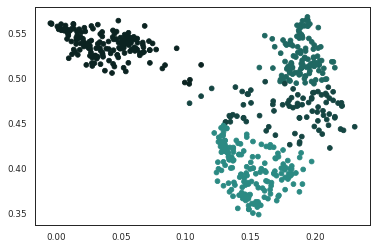

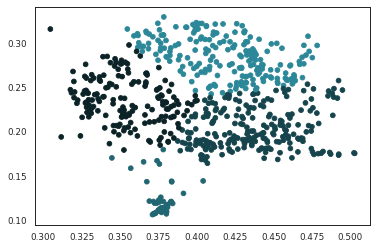

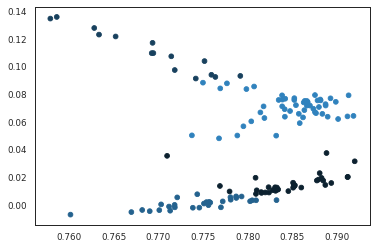

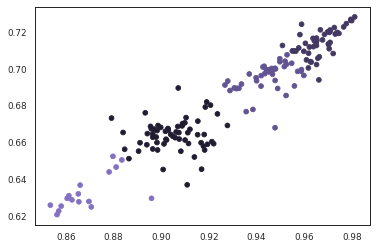

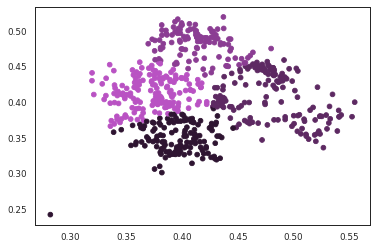

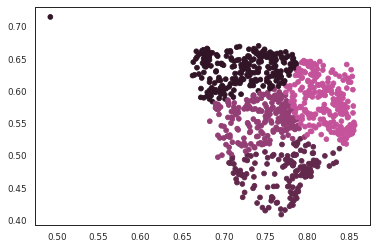

In [38]:
for i in range(12):
    cluster_idx = i

    plt.scatter(normalized_embeddings[cluster_idx][:,0], normalized_embeddings[cluster_idx][:,1], c = actual_cluster_colors[cluster_idx])
    plt.show()
# plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])

In [41]:
def denorm(xy_coord, translation_axis0= translation_axis0, translation_axis1=translation_axis1, scale_axis0=scale_axis0, scale_axis1=scale_axis1):

    clusters_denormed = [((xy_coord[0] * scale_axis0 )- translation_axis0), (xy_coord[1] * scale_axis1) - translation_axis1]
    clusters_denormed = np.array(clusters_denormed)
    return clusters_denormed

In [42]:
num_clusters = 12

subcluster_dict = {}
for i in range(num_clusters):
    
    subcluster_dict["subcluster"+str(i)] = ",".join([str(pt) for pt in list(normalized_embeddings[i].flatten())])

In [43]:
num_clusters = 12

subcluster_dict = {}
for i in range(num_clusters):
    mini_dict = {}
    norm_embedding3d = np.array([[x,y,0] for x,y in normalized_embeddings[i]])
    mini_dict["length"] = str(int(len([str(pt) for pt in norm_embedding3d]) / 3))
    mini_dict["subcluster"] = ",".join([str(pt) for pt in list(norm_embedding3d.flatten())])
    
    mini_dict["colors"] = ",".join([str(pt) for pt in actual_cluster_colors[i].flatten()])
    mini_dict["centers"] = ",".join([str(pt) for pt in kmeans_per_cluster[i].cluster_centers_.flatten()])
    
    denormed_centers = [denorm(center) for center in kmeans_per_cluster[i].cluster_centers_]
    ptcloud_from_centers = np.array(get_centroid_ptclouds(denormed_centers))
    ptcloud_from_centers = ptcloud_from_centers.flatten()
    mini_dict["representatives"] = ",".join([str(pt) for pt in ptcloud_from_centers])
    representative_colors = [desaturate(i,subcluster_idx) for subcluster_idx in range(4) ]
    representative_colors = np.array(representative_colors).flatten()
    mini_dict["representative_colors"] = ",".join([str(pt) for pt in representative_colors])
    subcluster_dict[i] = mini_dict

In [ ]:
denormed_x = (np.array(kmeans_per_cluster[i].cluster_centers_)[:,0] * scale_axis0) + translation_axis0
denormed_y = (np.array(kmeans_per_cluster[i].cluster_centers_)[:,1] * scale_axis1) + translation_axis1

denormed_centers = np.array(list(zip(denormed_x, denormed_y)))

In [ ]:
color_palette

In [ ]:

def run():
    app.run(host='0.0.0.0',port=5000, threaded=False)

run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://172.17.0.2:5000/ (Press CTRL+C to quit)
172.17.0.1 - - [24/Jun/2021 13:43:14] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:43:16] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:43:16] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:43:16] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:43:16] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:43:16] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:43:16] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:43:16] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:43:16] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:43:16] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:43:16] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:43:16] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:43:16] "POST /generate HTTP/1.1" 200 -
172.17.0

172.17.0.1 - - [24/Jun/2021 13:51:19] "POST /generate HTTP/1.1" 500 -
[2021-06-24 13:51:19,146] ERROR in app: Exception on /generate [POST]
Traceback (most recent call last):
  File "/root/anaconda3/envs/ai_clouds_py3/lib/python3.8/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/root/anaconda3/envs/ai_clouds_py3/lib/python3.8/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/root/anaconda3/envs/ai_clouds_py3/lib/python3.8/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/root/anaconda3/envs/ai_clouds_py3/lib/python3.8/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "<ipython-input-20-ae3675b78175>", line 81, in generate
    inverse_umap = dim_expansion[(point_as_key[0], point_as_key[1] + 0.01)]
KeyError: (0.5, 0.5

172.17.0.1 - - [24/Jun/2021 13:53:19] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:53:19] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:53:19] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:53:19] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:53:19] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:53:19] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:53:19] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:53:19] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:53:19] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:53:19] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:53:20] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:53:20] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:53:20] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:53:20] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/J

172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 13:56:10] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/J

172.17.0.1 - - [24/Jun/2021 14:00:36] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:00:37] "POST /subcluster HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:05:03] "POST / HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:05:05] "POST /subcluster HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:05:06] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:05:06] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:05:06] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:05:06] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:05:06] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:05:06] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:05:06] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:05:06] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:05:06] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:05:06] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2

172.17.0.1 - - [24/Jun/2021 14:06:38] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:06:38] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:06:38] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:06:38] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:06:39] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:06:39] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:06:39] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:06:40] "POST /subcluster HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:06:41] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:06:41] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:06:41] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:06:41] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:06:41] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24/Jun/2021 14:06:41] "POST /generate HTTP/1.1" 200 -
172.17.0.1 - - [24

In [166]:
kmeans_per_cluster[6].cluster_centers_

array([[0.15046167, 0.40004915],
       [0.19010715, 0.52413636],
       [0.03894628, 0.5381812 ],
       [0.18207595, 0.46540278]], dtype=float32)

In [130]:
denorm(kmeans_per_cluster[6].cluster_centers_[2], translation_axis0, translation_axis1, scale_axis0, scale_axis1)

array([-1.85779017,  7.25049591])

In [93]:
np.array(ptcloud_centers0).flatten()

24576

In [ ]:
def get_centroid_ptclouds(centers):
    
    inverted_centers = [reducer.inverse_transform(np.array(center).reshape((1,2))) for center in centers]
    
    ptclouds_from_centers = [decoder.predict(latent_center.reshape(1,1,1,128)) for latent_center in inverted_centers]
    return ptclouds_from_centers